In [2]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

In [3]:
# qutritium
import utility as ut
import constant
import numpy as np 
import matplotlib.pyplot as plt

In [4]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from utility import *

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['axes.linewidth'] = 2.0
%config InlineBackend.figure_formats = ['svg']

# Define your colormap
cmap_viridis = plt.cm.viridis  # You can choose any other colormap
cmap_plasma = plt.cm.plasma

# Gell-Mann matrices

In [6]:
gm1 = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
])

gm2 = np.array([
    [0, -1j, 0],
    [1j, 0, 0],
    [0, 0, 0]
])

gm3 = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 0]
])

gm6 = np.array([
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
])

gm7 = np.array([
    [0, 0, 0],
    [0, 0, -1j],
    [0, 1j, 0]
])

gm9 = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, -1]
])

# Computational basis

In [7]:
ket0 = np.array([[1], [0], [0]])
bra0 = ket0.T.conj()

ket1 = np.array([[0], [1], [0]])
bra1 = ket1.T.conj()

ket2 = np.array([[0], [0], [1]])
bra2 = ket2.T.conj()

# Rotations from Gell-Mann

Rotation includes over-rotation ($\epsilon >0$) and phase error ($\delta \neq 0$).

In [8]:
def RGM01(theta, epsilon, delta):
    '''
        Description
    '''
    
    H = ((theta+epsilon)/2)*gm1 - (delta*gm3)
    U = expm(-1j*H)
    
    return U

def RGM12(theta, epsilon, delta):
    '''
        Description
    '''
    
    H = ((theta+epsilon)/2)*gm6 - (delta*gm9)
    U = expm(-1j*H)
    
    return U

# Rabi oscillation (12)

In [10]:
rabi32exp_IQdata = np.load('./calibrator/ape_drag/data/rabi_osc/rabi_oscillation_cred3rq78n6g008e1wxg_-0.75_0.75.pkl', allow_pickle=True)
amp12_sweep_range = np.linspace(-0.75, 0.75, 100)

In [12]:
rabi32_exp_params, rabi32_exp_fit = ut.fit_function(
    amp12_sweep_range, rabi32exp_IQdata[:-2], lambda x, A, omega, phi, B: (A*np.cos(omega*x+phi)+B),
    [10, 2*np.pi/0.65, 0, 30]
)

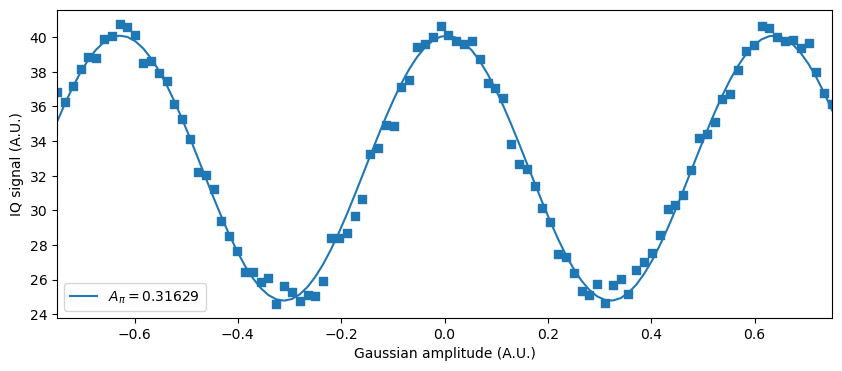

In [13]:
fig, (ax) = plt.subplots(ncols=1, figsize=(10, 4))

# Experiment 1
ax.scatter(amp12_sweep_range, rabi32exp_IQdata[:-2], marker='s')
ax.plot(amp12_sweep_range, rabi32_exp_fit, label=r'$A_\pi=$'+f'{round(2*np.pi/rabi32_exp_params[1]/2, 6)}')

ax.set_xlabel('Gaussian amplitude (A.U.)')
ax.set_ylabel('IQ signal (A.U.)')
ax.set_xlim([min(amp12_sweep_range), max(amp12_sweep_range)])
ax.legend()
    
# fig.savefig('./phase1/data/logical/step1_calibrating_pi_pulse/two_rabi.png', dpi=300)

In [14]:
x_amp_12 = round(2*np.pi/rabi32_exp_params[1]/2, 8)

x_amp_12

0.31629007

# Fit 2. Rough calibration of $X^{12}$

In [15]:
Ypi_data_pop2_plus = np.load('./calibrator/ape_drag/data/rough_x12/rough_x12_credzhpdjmqg008kgvd0_1357_minusPO0_mitiq.pkl', allow_pickle=True)
Ypi_data_pop2raw_plus = np.load('./calibrator/ape_drag/data/rough_x12/rough_x12_credzhpdjmqg008kgvd0_1357_minusPO0_raw.pkl', allow_pickle=True)

betas_12_rough = np.linspace(-1, 0.5, 150)

In [17]:
Ypi_data_pop2_plus = Ypi_data_pop2_plus[:-2]

In [18]:
Ypi_data_pop2raw_plus = Ypi_data_pop2raw_plus[:-2]

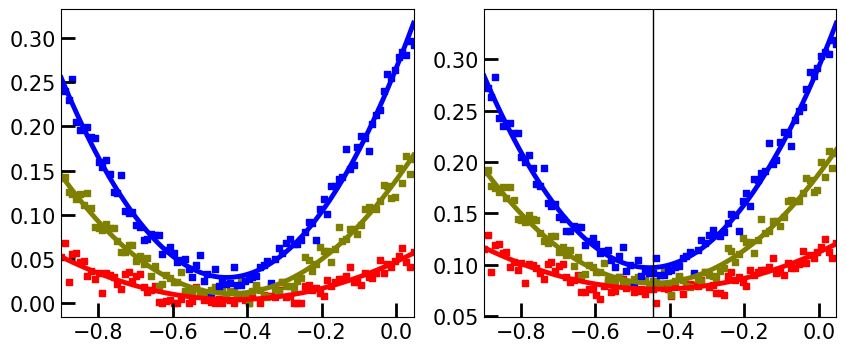

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
color = ['red', 'olive', 'blue', 'pink', 'brown', 'orange']
beta_corrections = []

min_idx, max_idx = 10, 105

i = 0
for reps in [3, 5, 7]:
    pop2 = Ypi_data_pop2_plus[i*150:(i+1)*150][min_idx:max_idx]
    pop2_plus = Ypi_data_pop2raw_plus[i*150:(i+1)*150][min_idx:max_idx]
    beta_fit_range = betas_12_rough[min_idx:max_idx]
    
    ax1.scatter(beta_fit_range, pop2, s=20, marker='s', color=color[i])
    ax2.scatter(beta_fit_range, pop2_plus, s=20, marker='s', color=color[i])
    
    param, yfit = ut.fit_function(beta_fit_range, pop2, 
                              lambda x, A, B, x0: (A+B*(x-x0)**2),
                              [0, 1, 2.5])
    
    param_plus, yfit_plus = ut.fit_function(beta_fit_range, pop2_plus, 
                          lambda x, A, B, x0: (A+B*(x-x0)**2),
                          [0, 1, 2.5])
    
    ax1.plot(beta_fit_range, yfit, color=color[i], linewidth=3.5)
    ax2.plot(beta_fit_range, yfit_plus, color=color[i], linewidth=3.5)
    beta_corrections.append([param[2], param_plus[2]])
    i += 1

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
    ax.tick_params(axis='both', which='major', length=10, width=2.0)
#     ax.xaxis.set_major_locator(MultipleLocator(0.5))
#     ax.yaxis.set_major_locator(MultipleLocator(0.02))
    ax.set_xlim([betas_12_rough[min_idx], betas_12_rough[max_idx-1]])

plt.axvline(sum(beta_corrections[1])/len(beta_corrections[1]), linewidth=1.0, color='black')

In [21]:
sum(beta_corrections[1])/len(beta_corrections[1])

-0.4447280494872925

In [22]:
beta_corrections

[[-0.4359654131756506, -0.43633206399779917],
 [-0.4446730574629842, -0.44478304151160075],
 [-0.45478986478462236, -0.45482766512256806]]

# Simulation 1. Over-rotation amplifying sequence

In [12]:
epsilon = pi/128
delta = 0

In [13]:
pop2_sim = []
even_reps = [2*i for i in range(20)]

for n in even_reps:
    state_vector = RGM12(pi/2, epsilon, 0) @ RGM01(pi, 0, 0) @ ket0
    for j in range(n):
        state_vector = RGM12(pi/2, epsilon, 0) @ state_vector
    pop2 = np.abs((bra2 @ state_vector)[0])**2
    pop2_sim.append(pop2)

In [35]:
def OAS90(x, epsilon, delta):
    
    state_vector = RGM12(pi/2, epsilon, delta) @ RGM01(pi, 0, 0) @ ket0
    
    for _ in range(x):
        state_vector = RGM12(pi/2, epsilon, delta) @ state_vector
                
    pop2 = np.abs((bra2 @ state_vector)[0])**2
        
    return pop2[0]

In [36]:
OAS90_sim(0, pi/128, 0.2*pi/128)

0.5122663139403818

In [37]:
even_reps = np.asarray(even_reps)
pop2_RAA90_data = np.asarray(pop2_RAA90_data)

In [38]:
even_reps

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38])

In [92]:
pop2_RAA90_data = np.load('./phase1/data/pop2_RAA90_data.pkl', allow_pickle=True)
pop2_RAA180_data = np.load('./phase1/data/pop2_RAA180_data.pkl', allow_pickle=True)

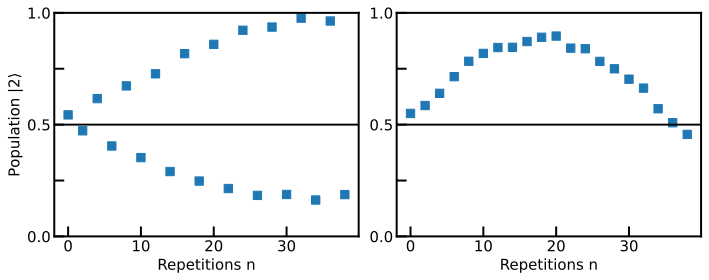

In [94]:
even_reps = np.array([2*i for i in range(20)])

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(10, 4))

ax1.scatter(even_reps, pop2_RAA90_data, marker='s', s=70, label='Default')
# ax1.plot(even_reps, OAS90_fit)
ax2.scatter(even_reps, pop2_RAA180_data, marker='s', s=70, label='Default')
    
for ax in [ax1, ax2]:
    ax.set_xlabel(r'Repetitions n', size=15)
    ax.axhline(0.5, label='Ideal', color='black', linewidth=2)
    ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
    ax.tick_params(axis='both', which='major', length=10, width=2)
    ax.tick_params(axis='both', which='minor', length=10, width=2)
    ax.set_ylim([0, 1.0])
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax1.set_ylabel(r'Population $|2\rangle$', size=15)

fig.tight_layout()
# fig.savefig('./phase1/data/logical/step1_calibrating_pi_pulse/3_check_AA_protocol.png', dpi=300, bbox_inches='tight')

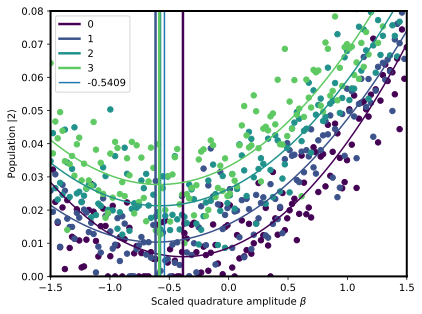

In [96]:
beta_corrections = []

for i in range(4):
    color = cmap(gradient_colors[i])
    plt.scatter(betas_12_rough, Ypi_data_pop2[(0+i*150):(0+(i+1)*150)], s=30, color=color)
    param, yfit = fit_function(betas_12_rough, Ypi_data_pop2[(0+i*150):(0+(i+1)*150)], 
                                  lambda x, A, B, x0: (A+B*(x-x0)**2),
                                  [0, 1, -0.5])
    plt.plot(betas_12_rough, yfit, color=color)
    plt.axvline(param[2], linewidth=2.5, color=color, label=f'{i}')
    beta_corrections.append(param[2])

plt.ylim([0, 0.08])
plt.xlim([min(betas_12_rough), max(betas_12_rough)])
plt.axvline(sum(beta_corrections)/len(beta_corrections), label=f'{round(sum(beta_corrections)/len(beta_corrections),4)}')
plt.xlabel(r'Scaled quadrature amplitude $\beta$')
plt.ylabel(r'Population $|2\rangle$')
plt.legend()

# Fit 3. APE sequence

In [97]:
ape_data_pop1 = np.load('./phase1/data/ape_data_pop1.pkl', allow_pickle=True)
ape_data_pop2 = np.load('./phase1/data/ape_data_pop2.pkl', allow_pickle=True)

In [98]:
reps = [0, 1, 3, 5, 7]

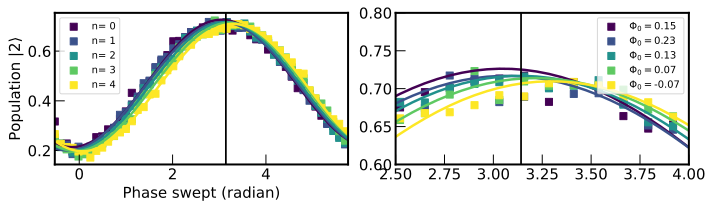

In [99]:
phase_sweep = np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100)

population2_ape = []
ape_params = []
ape_fits = []
initial_phases = []

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

for j in range(5):
    color = cmap(gradient_colors[j])
    population2_ape.append(ape_data_pop2[j*100:(j+1)*100])
    param, fit = fit_function(phase_sweep, population2_ape[j], 
                                      lambda x, A, B, omega, phi: (A*np.cos(omega*x+phi)+B),
                                      [0.5, 0.5, 1, 0])
    ape_params.append(param)
    ape_fits.append(fit)
    initial_phases.append(param[3])
    ax1.scatter(phase_sweep[::2], population2_ape[j][::2], marker='s', s=50, label=r'n= '+f'{j}', color=color)
    ax2.scatter(phase_sweep[::2], population2_ape[j][::2], marker='s', s=50, label=r'$\Phi_0=$'+f'{round(param[3],2)}', color=color)
    ax1.plot(phase_sweep, ape_fits[j], linewidth=2.5, color=color)
    ax2.plot(phase_sweep, ape_fits[j], linewidth=2.5, color=color)
    

ax1.set_xlim([min(phase_sweep), max(phase_sweep)])
ax2.set_xlim([2.5, 4])
ax2.set_ylim([0.6, 0.8])
ax1.set_xlabel('Phase swept (radian)', size=15)
ax1.set_ylabel(r'Population $|2\rangle$', size=15)

for ax in [ax1, ax2]:
    ax.axvline(3.1415926535897932, color='black', linewidth=1.75)
    ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
    ax.tick_params(axis='both', which='major', length=10, width=1.0)
    ax.tick_params(axis='both', which='minor', length=7, width=1.0)
    ax.legend()
    
fig.tight_layout()
# plt.savefig('./phase1/data/logical/step2_calibrating_halfpi_pulse/1_ape_halfpi_NO_correction.png', dpi=300)

# Fit 4. Y correction obtained with APE

In [6]:
apeY_data_pop2 = np.load('./calibrator/ape_drag/data/ape_drag/pop2_sx12_crmdtxktdjr0008dz8fg_-2_to_1_3577.pkl', allow_pickle=True)

In [7]:
apeYcorrection_pop2 = []

beta_sweep_vals = np.linspace(-2.0, 1.0, 150)
length = len(beta_sweep_vals)

for j in range(4):
    apeYcorrection_pop2.append(apeY_data_pop2[j*length:(j+1)*length])

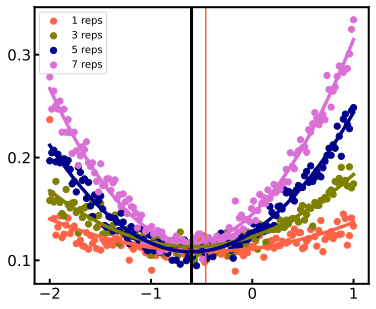

In [8]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 5))
color_pallete = ['tomato', 'olive', 'darkblue', 'orchid', 'coral', 'yellowgreen']

beta_corrections = []

for idx, pop in enumerate(apeYcorrection_pop2):
    color = color_pallete[idx]
    beta_swept = beta_sweep_vals
    population_2 = pop
    
    ax.scatter(beta_swept, population_2, s=40, marker='o', color=color, label=f'{2*idx+1}'+' reps')
    
    param, yfit = fit_function(beta_swept, population_2, 
                              lambda x, A, B, x0: (A*(x-x0)**2+B),
                              [10, 0.1, 2])
    beta_corrections.append(param[2])
    
    ax.plot(beta_swept, yfit, linewidth=3.5, color=color)
    ax.axvline(param[2], color=color)
    
# ax.set_xlim([min(beta_sweep_vals), max(beta_sweep_vals)])
# ax.set_ylim([-0.03, 0.3])
ax.legend()
ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
ax.tick_params(axis='both', which='major', length=5, width=2.0)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.axvline(sum(beta_corrections[1:])/len(beta_corrections[1:]), linewidth=3.0, color='black')

In [9]:
beta_corrections

[-0.4594134539713138,
 -0.5949951391021686,
 -0.6008059204347901,
 -0.6032308412706848]

# RPC mixed sequence

array([3.42093543, 4.71690756])

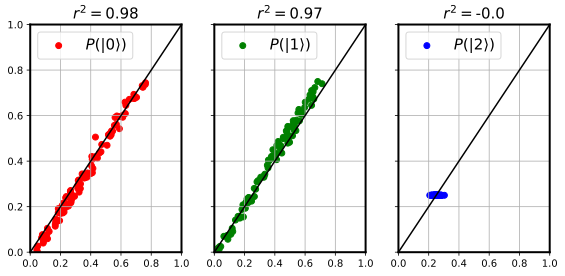

In [24]:
order_chain = '000'
num_circs = 100
job_id = 'cqrn7w7hnkbg008fynag'

population_experiment = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_experiment.pkl', allow_pickle=True)
population_model = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_model.pkl', allow_pickle=True)
phase_advance = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'x_optimum.pkl', allow_pickle=True)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True)
xplt = np.linspace(0, 1, 1000)
colors = ['r', 'g', 'b']

for i in range(3):
    p_model = [p[i] for p in population_experiment]
    p_exp = [p[i] for p in population_model]
    axes[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    axes[i].plot(xplt, xplt, color='black')
    axes[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axes[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axes[i].grid()
    axes[i].legend(fontsize=15)

fig.tight_layout()

phase_advance

array([0.3712844 , 3.87736572])

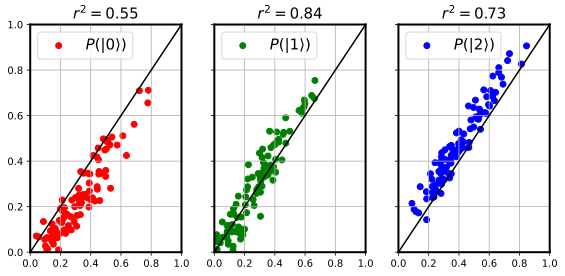

In [31]:
order_chain = '010'
num_circs = 100
job_id = 'cqs973436d60008fvm7g'

population_experiment = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_experiment.pkl', allow_pickle=True)
population_model = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_model.pkl', allow_pickle=True)
phase_advance = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'x_optimum.pkl', allow_pickle=True)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True)
xplt = np.linspace(0, 1, 1000)
colors = ['r', 'g', 'b']

for i in range(3):
    p_model = [p[i] for p in population_experiment]
    p_exp = [p[i] for p in population_model]
    axes[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    axes[i].plot(xplt, xplt, color='black')
    axes[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axes[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axes[i].grid()
    axes[i].legend(fontsize=15)

fig.tight_layout()

phase_advance

array([3.53030359, 3.9318668 ])

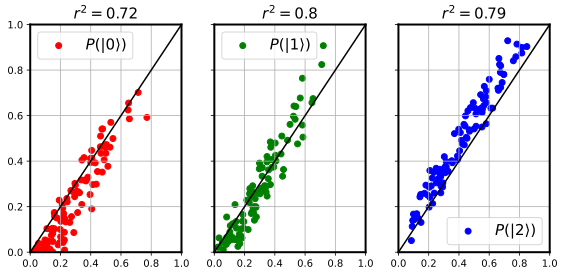

In [30]:
order_chain = '0100'
num_circs = 100
job_id = 'cqs8zt736d60008fvksg'

population_experiment = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_experiment.pkl', allow_pickle=True)
population_model = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_model.pkl', allow_pickle=True)
phase_advance = np.load('./phase2/two_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'x_optimum.pkl', allow_pickle=True)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True)
xplt = np.linspace(0, 1, 1000)
colors = ['r', 'g', 'b']

for i in range(3):
    p_model = [p[i] for p in population_experiment]
    p_exp = [p[i] for p in population_model]
    axes[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    axes[i].plot(xplt, xplt, color='black')
    axes[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axes[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axes[i].grid()
    axes[i].legend(fontsize=15)

fig.tight_layout()
phase_advance

# Same data, different model

array([0.77587642, 1.088534  , 0.49154417])

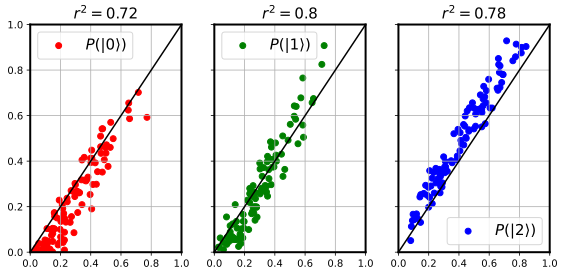

In [29]:
order_chain = '0100'
num_circs = 100
job_id = 'cqs8zt736d60008fvksg'

population_experiment = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_experiment.pkl', allow_pickle=True)
population_model = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_model.pkl', allow_pickle=True)
phase_advance = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'x_optimum.pkl', allow_pickle=True)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True)
xplt = np.linspace(0, 1, 1000)
colors = ['r', 'g', 'b']

for i in range(3):
    p_model = [p[i] for p in population_experiment]
    p_exp = [p[i] for p in population_model]
    axes[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    axes[i].plot(xplt, xplt, color='black')
    axes[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axes[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axes[i].grid()
    axes[i].legend(fontsize=15)

fig.tight_layout()
phase_advance

array([0.74102043, 5.63486372, 2.1214799 ])

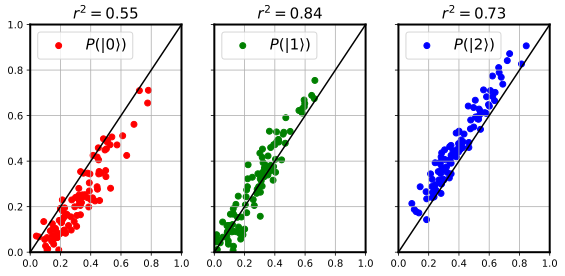

In [28]:
order_chain = '010'
num_circs = 100
job_id = 'cqs973436d60008fvm7g'

population_experiment = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_experiment.pkl', allow_pickle=True)
population_model = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_model.pkl', allow_pickle=True)
phase_advance = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'x_optimum.pkl', allow_pickle=True)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True)
xplt = np.linspace(0, 1, 1000)
colors = ['r', 'g', 'b']

for i in range(3):
    p_model = [p[i] for p in population_experiment]
    p_exp = [p[i] for p in population_model]
    axes[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    axes[i].plot(xplt, xplt, color='black')
    axes[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axes[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axes[i].grid()
    axes[i].legend(fontsize=15)

fig.tight_layout()
phase_advance

array([0.40021147, 6.06436027, 1.90981051])

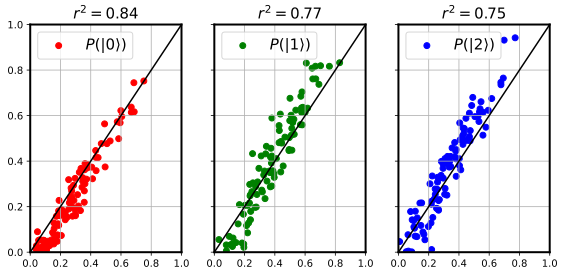

In [25]:
order_chain = '0101'
num_circs = 100
job_id = 'cqt7qr7ch2mg008qv600'

population_experiment = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_experiment.pkl', allow_pickle=True)
population_model = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'population_model.pkl', allow_pickle=True)
phase_advance = np.load('./phase2/three_parameter/RPC'+f'_{order_chain}'+f'_{num_circs}'+f'_{job_id}/'+'x_optimum.pkl', allow_pickle=True)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True)
xplt = np.linspace(0, 1, 1000)
colors = ['r', 'g', 'b']

for i in range(3):
    p_model = [p[i] for p in population_experiment]
    p_exp = [p[i] for p in population_model]
    axes[i].scatter(p_model, p_exp, color = colors[i], label=fr'$P(|{i}\rangle)$')
    axes[i].plot(xplt, xplt, color='black')
    axes[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    axes[i].set_title(r'$r^2 = $' + str(np.round(r2_score(p_model, p_exp), 2)) , size=15)
    axes[i].grid()
    axes[i].legend(fontsize=15)

fig.tight_layout()

phase_advance